In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
data = pd.read_csv("../../../data/bikes_rent.csv")

In [6]:
data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [12]:
data.shape

(731, 13)

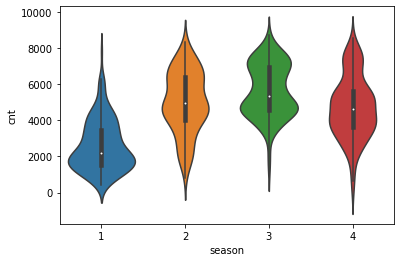

In [13]:
sns.violinplot(x='season', y='cnt', data=data);

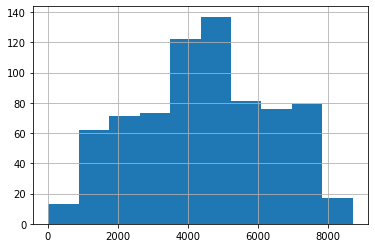

In [14]:
data["cnt"].hist();

In [15]:
X_df, y_series = data.drop("cnt", axis=1), data["cnt"]

In [16]:
X_df.shape

(731, 12)

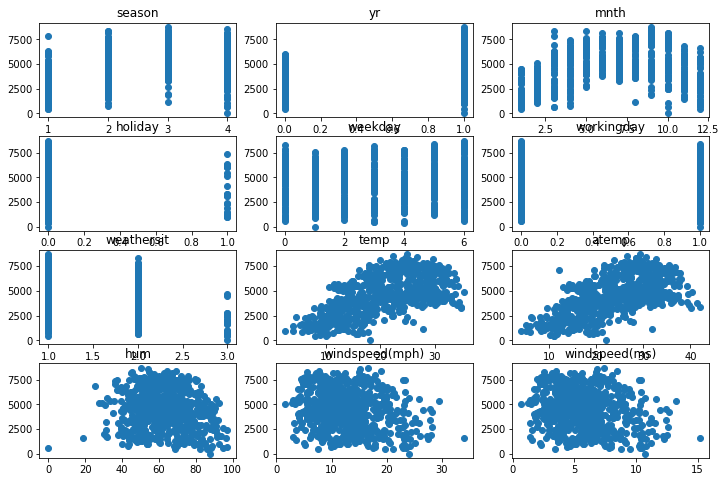

In [17]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(X_df.columns):
    plt.subplot(4, 3, i + 1)
    plt.scatter(X_df[col], y_series)
    plt.title(col);

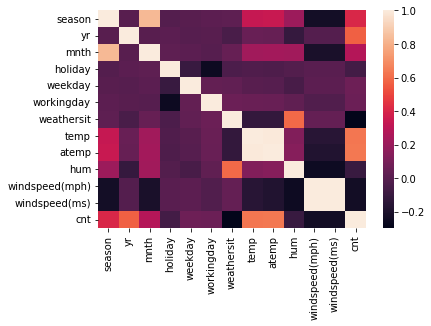

In [18]:
sns.heatmap(data.corr());

In [25]:
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler

In [30]:
linreg = LinearRegression()
lasso = Lasso(random_state=17)
ridge = Ridge(random_state=17)
lasso_cv = LassoCV(random_state=17)
ridge_cv = RidgeCV()

In [31]:
X, y = data.drop('cnt', axis=1), data['cnt']

In [32]:
train_share = 0.7
train_part_size = int(train_share * data.shape[0])

X_train = X_df.values[:train_part_size, :]
X_valid = X_df.values[train_part_size:, :]
y_train = y_series.values[:train_part_size]
y_valid = y_series.values[train_part_size:]

In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [34]:
linreg.fit(X_train_scaled, y_train)

LinearRegression()

In [36]:
np.sqrt(mean_squared_error(y_valid, linreg.predict(X_valid_scaled)))

1121.7959174734228

<AxesSubplot:>

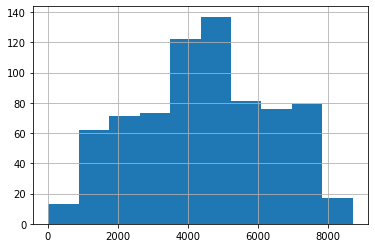

In [37]:
data['cnt'].hist()

In [41]:
pd.DataFrame(linreg.coef_, data.columns[:-1], columns=['coef']).sort_values(by='coef', ascending=False)

,coef
windspeed(ms),3.051193e+12
yr,9.540706e+02
atemp,8.911709e+02
season,4.048576e+02
weekday,1.037114e+02
temp,6.248634e+01
mnth,3.081084e+01
workingday,1.470224e+01
holiday,-6.757366e+01
hum,-1.589777e+02


In [64]:
def train_validate_report(model, X_train_scaled, y_train,
                         X_valid_scaled, y_valid, feature_names, forest=False):
    model.fit(X_train_scaled, y_train)
    print('MSE=%f' % np.sqrt(mean_squared_error(y_valid, model.predict(X_valid_scaled))))
    coefs = model.coef_ if not forest else model.feature_importances_
    print(pd.DataFrame(coefs, data.columns[:-1], columns=['coef']).sort_values(by='coef', ascending=False))

In [65]:
train_validate_report(lasso, X_train_scaled, y_train,
                         X_valid_scaled, y_valid, feature_names=data.columns[:-1] )

MSE=1120.721409
                      coef
yr              952.804560
atemp           877.159813
season          403.416439
weekday         102.643044
temp             75.953962
mnth             29.857599
workingday       14.173377
windspeed(ms)    -0.000000
holiday         -67.073435
hum            -157.547615
windspeed(mph) -187.341353
weathersit     -293.177257


In [66]:
train_validate_report(lasso_cv, X_train_scaled, y_train,
                         X_valid_scaled, y_valid, feature_names=data.columns[:-1] )

MSE=1120.743661
                      coef
yr              951.135002
atemp           883.344030
season          403.009581
weekday         101.892690
temp             69.238981
mnth             28.608639
workingday       13.478682
windspeed(ms)    -0.000000
holiday         -66.360460
hum            -156.248289
windspeed(mph) -186.267734
weathersit     -293.016582


In [67]:
train_validate_report(ridge, X_train_scaled, y_train,
                         X_valid_scaled, y_valid, feature_names=data.columns[:-1] )

MSE=1119.560520
                      coef
yr              954.075878
atemp           730.747340
season          400.114172
temp            221.406072
weekday         103.198680
mnth             34.687740
workingday       15.334339
holiday         -69.046689
windspeed(ms)   -95.819798
windspeed(mph)  -95.819798
hum            -157.702520
weathersit     -293.899386


In [68]:
train_validate_report(ridge_cv, X_train_scaled, y_train,
                         X_valid_scaled, y_valid, feature_names=data.columns[:-1] )

MSE=1118.903543
                      coef
yr              934.401985
atemp           534.482125
temp            410.485392
season          375.585733
weekday         100.838401
mnth             48.142392
workingday       16.165284
holiday         -70.019251
windspeed(ms)   -97.770430
windspeed(mph)  -97.770430
hum            -155.174377
weathersit     -291.035853


In [69]:
def rmse(y, p):
    return np.sqrt(mean_squared_error(y, p))

In [70]:
from sklearn.ensemble import RandomForestRegressor

In [71]:
forest = RandomForestRegressor(n_estimators=100, random_state=17)

In [72]:
train_validate_report(forest,X_train_scaled, y_train,
                         X_valid_scaled, y_valid, feature_names=data.columns[:-1], forest=True)

MSE=1054.089106
                    coef
temp            0.324132
atemp           0.216861
yr              0.200795
hum             0.067893
season          0.064054
weathersit      0.032349
mnth            0.028291
windspeed(ms)   0.020298
weekday         0.018796
windspeed(mph)  0.017695
workingday      0.006051
holiday         0.002783
